<a href="https://colab.research.google.com/github/cumason123/NCAA-NBA-Picker/blob/master/Game_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Summary: Uses neural networks to predict outcomes of games

All work done in this colab is by Julius Frost  
https://github.com/juliusfrost  
https://linkedin.com/in/juliusfrost/

# Import necessary data and libraries

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#tf.enable_eager_execution()



Authenticated


###Download dataset

In [0]:
!gsutil cp gs://stardust-hackathon/ncaa-mbb/player_box.csv /tmp/

df = pd.read_csv("/tmp/player_box.csv")

Copying gs://stardust-hackathon/ncaa-mbb/player_box.csv...
- [1 files][ 71.6 MiB/ 71.6 MiB]                                                
Operation completed over 1 objects/71.6 MiB.                                     


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

##Formatting

### check data format

In [0]:
print(df.head(10))

   team_code  season             game_id   game_date  player_id jersey_num  \
0      768.0    2018    327-768-2019-1-9  2019-01-09  2082634.0          1   
1      768.0    2018   698-768-2019-1-15  2019-01-15  2082634.0          1   
2      768.0    2018  768-606-2018-11-18  2018-11-18  2082634.0          1   
3      768.0    2018  768-352-2018-12-30  2018-12-30  2082634.0          1   
4      768.0    2018   768-521-2019-1-12  2019-01-12  2082634.0          1   
5      768.0    2018    768-51-2019-1-21  2019-01-21  2082634.0          1   
6      768.0    2018  768-315-2018-12-22  2018-12-22  2082634.0          1   
7      768.0    2018    703-768-2019-1-5  2019-01-05  2082634.0          1   
8      768.0    2018   768-328-2019-1-19  2019-01-19  2082634.0          1   
9      768.0    2018    768-700-2019-1-2  2019-01-02  2082634.0          1   

    pts   fga  fga3  fgm     ...       ast  blk  stl  dreb  oreb   reb   pf  \
0  17.0  14.0   0.0  7.0     ...       0.0  1.0  0.0   5.0   7

### drop NANs

In [0]:
df = df.dropna()

### unique stats

In [0]:
game_ids = df['game_id'].unique()
print('Number of unique games in the dataset =',len(game_ids))

Number of unique games in the dataset = 34006


In [0]:
player_ids = df['player_id'].unique().astype('int32')
print('Number of unique players in the dataset =', len(player_ids))

Number of unique players in the dataset = 33730


### separate data by players

In [0]:
player_data = []
for i, player in enumerate(player_ids):
    if i % 1000 == 0:
        print(i)
    player_data.append(df[df['player_id'] == player].values)
print(len(player_data))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
33730


###separate data by game

In [0]:
game_data = []
for i, game in enumerate(game_ids):
    if i > 100:
        break
    game_data.append(df[df['game_id'] == game].values)
print(len(game_data))
print(len(game_data[0]))

101
22


### show data statistics

In [0]:
print(type(player_data), type(player_data[0]))
#print(player_data[0])
print('example data for one game of one player')
print(player_data[0][0])
print()

games_available = []
num_players = len(player_data)
for player_info in player_data:
    number_games = len(player_info)
    games_available.append(number_games)

median_games = np.median(games_available)
mean_games = np.mean(games_available)
std_games = np.std(games_available)

print('median_games =',median_games)
print('mean_games =',mean_games)
print('std_games =',std_games)

<class 'list'> <class 'numpy.ndarray'>
example data for one game of one player
[768.0 2018 '327-768-2019-1-9' '2019-01-09' 2082634.0 1 17.0 14.0 0.0 7.0
 0.0 5.0 3.0 0.0 1.0 0.0 5.0 7.0 12.0 1.0 0.0 1.0 34.0]

median_games = 14.0
mean_games = 21.100711532760155
std_games = 25.962066607791115


##Visualization

###  Plot the number of games per player
Notice that very many only played a couple games, while there are multiple modes for more experienced players. The distribution thins with the amount of games, since it is less common for people to spend a lot of time in NCAA.
My hypothesis is that the modes depend on the number of years you spend in college and the number of games there are in a season.
So the mode locations will be a equal to seasons per player * games per season.


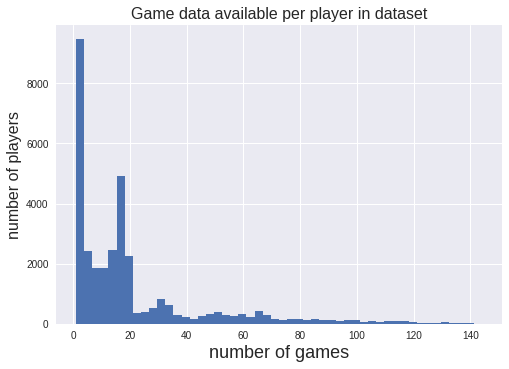

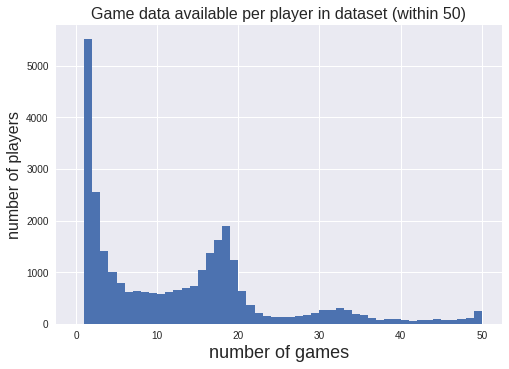

In [0]:
plt.hist(games_available, bins=50)
plt.title('Game data available per player in dataset', fontsize = 16)
plt.xlabel('number of games', fontsize=18)
plt.ylabel('number of players', fontsize=16)
plt.show()

plt.hist(games_available, bins=50, range=(0,50))
plt.title('Game data available per player in dataset (within 50)', fontsize = 16)
plt.xlabel('number of games', fontsize=18)
plt.ylabel('number of players', fontsize=16)
plt.show()

## Create training data

In [0]:
training_features = df.loc[:, 'pts':'mins_played':1].astype('float32').values
training_labels = df['player_id'].astype('int32').values

print(training_features.shape)
print(training_features[:5])
print(training_labels.shape)
print(training_labels[:5])

(711727, 17)
[[17. 14.  0.  7.  0.  5.  3.  0.  1.  0.  5.  7. 12.  1.  0.  1. 34.]
 [ 8.  4.  0.  3.  0.  4.  2.  2.  0.  0.  3.  1.  4.  3.  0.  0. 22.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [11.  6.  0.  4.  0.  7.  3.  1.  1.  0.  5.  6. 11.  2.  0.  1. 19.]
 [15.  8.  0.  5.  0.  6.  5.  1.  2.  1. 11.  4. 15.  3.  0.  1. 27.]]
(711727,)
[2082634 2082634 2082634 2082634 2082634]


In [0]:
num_examples, num_features = training_features.shape
num_labels = len(player_ids)

print('num_examples =',num_examples)
print('num_features =',num_features)
print('num_labels =',num_labels)

num_examples = 711727
num_features = 17
num_labels = 33730


In [0]:
to_index = dict()
to_player_id = dict()
for i, player in enumerate(player_ids):
    to_index.update({player:i})
    to_player_id.update({i:player})

In [0]:
for i, player in enumerate(training_labels):
    training_labels[i] = to_index[player]

In [0]:
batch_size = 2**18
print('batch_size =', batch_size)

#dataset = dataset.shuffle(buffer_size=100)
dataset = tf.data.Dataset.from_tensor_slices((training_features, training_labels))
dataset = dataset.batch(batch_size).repeat()
print(dataset.output_shapes)

batch_size = 262144
(TensorShape([Dimension(None), Dimension(17)]), TensorShape([Dimension(None)]))


#Training a model

### Auto Encoder

In [0]:
num_inputs = num_features
num_hid1 = 64
num_hid2 = 10
num_hid3 = num_hid1
num_output = num_labels
learning_rate = 0.0001
activation = tf.nn.relu

In [0]:
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

initializer = tf.variance_scaling_initializer()

w1 = tf.Variable(initializer([num_inputs, num_hid1]), dtype = tf.float32)
w2 = tf.Variable(initializer([num_hid1, num_hid2]), dtype = tf.float32)
w3 = tf.Variable(initializer([num_hid2, num_hid3]), dtype = tf.float32)
w4 = tf.Variable(initializer([num_hid3, num_output]), dtype = tf.float32)

b1 = tf.Variable(tf.zeros(num_hid1))
b2 = tf.Variable(tf.zeros(num_hid2))
b3 = tf.Variable(tf.zeros(num_hid3))
b4 = tf.Variable(tf.zeros(num_output))

hid_layer1 = activation(tf.matmul(features, w1) + b1)
hid_layer2 = activation(tf.matmul(hid_layer1, w2) + b2)
hid_layer3 = activation(tf.matmul(hid_layer2, w3) + b3)
logits = tf.matmul(hid_layer3, w4) + b4

In [0]:
one_hot_labels = tf.one_hot(labels, num_labels)

loss = tf.losses.softmax_cross_entropy(one_hot_labels, logits)


optimizer=tf.train.AdamOptimizer(learning_rate)
train=optimizer.minimize(loss)

init=tf.global_variables_initializer()

In [0]:
n_batches = num_examples // batch_size
print('number of batches = ',n_batches)
print('initializing...')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # initialise iterator with train data
    sess.run(iter.initializer)
    print('Training...')
    for i in range(100000):
        tot_loss = 0
        for j in range(n_batches):
            _, loss_value = sess.run([train, loss])
            tot_loss += loss_value
            #print("Batch: {}, Loss: {:.4f}".format(j, loss_value))
        if i % 1000 == 0:
            print("Iter: {}, Loss: {:.4f}".format(i, tot_loss / n_batches))
    # initialise iterator with test data
    #sess.run(iter.initializer, feed_dict={ x: test_data[0], y: test_data[1], batch_size: test_data[0].shape[0]})
    #print('Test Loss: {:4f}'.format(sess.run(loss)))


number of batches =  2
initializing...
Training...
Iter: 0, Loss: 7.8739
Iter: 1000, Loss: 10.4432
Iter: 2000, Loss: 10.4524
Iter: 3000, Loss: 10.4585
Iter: 4000, Loss: 10.3953
Iter: 5000, Loss: 10.4882
Iter: 6000, Loss: 10.4714
Iter: 7000, Loss: 10.3561
Iter: 8000, Loss: 10.4754
Iter: 9000, Loss: 10.4453
Iter: 10000, Loss: 10.4391
Iter: 11000, Loss: 10.5489
Iter: 12000, Loss: 10.5450
Iter: 13000, Loss: 10.5731
Iter: 14000, Loss: 10.5740
Iter: 15000, Loss: 10.4328
Iter: 16000, Loss: 10.5898
Iter: 17000, Loss: 10.5586
Iter: 18000, Loss: 10.6118
Iter: 19000, Loss: 10.6463
Iter: 20000, Loss: 10.6250
Iter: 21000, Loss: 10.6101
Iter: 22000, Loss: 10.6663
Iter: 23000, Loss: 10.6120
Iter: 24000, Loss: 10.6742
Iter: 25000, Loss: 10.6888
Iter: 26000, Loss: 10.6982
Iter: 27000, Loss: 10.6493
Iter: 28000, Loss: 10.7303
Iter: 29000, Loss: 10.7355
Iter: 30000, Loss: 10.7377
Iter: 31000, Loss: 10.6976
Iter: 32000, Loss: 10.7440
Iter: 33000, Loss: 10.6191
Iter: 34000, Loss: 10.7896
Iter: 35000, Loss:

###RNN model
Used previously to predict the box stats for the next game for a player given previous game box stats

In [0]:
import tensorflow as tf
from tensorflow.contrib import rnn


# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 1
display_step = 200

# Network Parameters
num_input = 17
timesteps = 9 # timesteps
num_hidden = 128 # hidden layer num of features
num_scores = 1 

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_scores])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_scores]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_scores]))
}


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
prediction = tf.nn.sigmoid(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()



# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = (x.values,y.values)  ######mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        batch_y = batch_y.reshape((timesteps, num_scores))
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    test_len = 1
    test_data = x.values.reshape(1,9,17)
    test_label = y.values.reshape(9,1)
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

In [0]:
ytest = list(player_info.loc[:, 'pts'][:-1])
#print(ytest)
s = 0
alpha = 0.7
average = 0
for i in range(0,9-1):
    s = alpha * s + (1-alpha) * ytest[i]
    average += abs(s - ytest[i+1])/(max(ytest[i+1], s))
average /= 9
print('exponential average estimation accuracy')
print(average)